   # **Detectarea Anomaliilor**

## Detectarea fraudelor cărților de credit
*Costea Carmen Andreea 334AB*

# Descrierea problemei

 Acest proiect se ocupă cu detectarea fraudelor în cazul tranzacțiilor cu cărți de credit, rezolvând astfel o provocare importantă din domeniul financiar.


 În [setul de date folosit](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data) sunt dominante anomaliile de tip cluster, deoarece tranzacțiile frauduluase nu apar izolat, ci formează grupuri cu caracteristici similare(sume, succesiune rapidă, tipare PCA) în zone cu densitate redusă.
   
În acest proiect, am implementat trei modele pentru detectarea tranzacțiilor frauduloase: KNN (K-Nearest Neighbors), LODA (Lightweight Online Detector of Anomalies) și One-Class SVM (OCSVM), preluate din biblioteca Python PyOD, specializată în identificarea valorilor anormale.
  
Am ales aceste modele pentru a acoperi diverse abordări asupra problemei:o metodă bazată pe proximitate(KNN), o metodă probabilistică (LODA) și o metodă bazată pe frontiere de decizie(OCSVM).



# Descrierea setului și explorarea setului de date

## 1) Prezentarea setului de date
Setul de date ales cuprinde tranzacții efectuate cu cardul de credit în septembrie 2013, de către cetățeni europeni.  
Setul conține în total 284807 tranzactii, dispuse pe 31 de coloane:

*   Coloanele V1, V2, ...V28 sunt rezultatul unei transformări PCA(Principal
Component Analysis) , utilizată pentru a respecta confidențialitatea datelor.
*   Coloana "Time": timpul de la prima tranzacție
* Coloana "Amount": suma tranzacției
* Coloana "Class": 0 pentru tranzacții legitime și 1 pentru fraude



In [19]:
# CELULA 1 - Incarcare date

!pip install pyod

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('creditcard.csv')
print(df.shape)

print(df.head())

(284807, 31)
    Time      V1      V2     V3      V4      V5      V6      V7      V8  \
0 0.0000 -1.3598 -0.0728 2.5363  1.3782 -0.3383  0.4624  0.2396  0.0987   
1 0.0000  1.1919  0.2662 0.1665  0.4482  0.0600 -0.0824 -0.0788  0.0851   
2 1.0000 -1.3584 -1.3402 1.7732  0.3798 -0.5032  1.8005  0.7915  0.2477   
3 1.0000 -0.9663 -0.1852 1.7930 -0.8633 -0.0103  1.2472  0.2376  0.3774   
4 2.0000 -1.1582  0.8777 1.5487  0.4030 -0.4072  0.0959  0.5929 -0.2705   

       V9  ...     V21     V22     V23     V24     V25     V26     V27  \
0  0.3638  ... -0.0183  0.2778 -0.1105  0.0669  0.1285 -0.1891  0.1336   
1 -0.2554  ... -0.2258 -0.6387  0.1013 -0.3398  0.1672  0.1259 -0.0090   
2 -1.5147  ...  0.2480  0.7717  0.9094 -0.6893 -0.3276 -0.1391 -0.0554   
3 -1.3870  ... -0.1083  0.0053 -0.1903 -1.1756  0.6474 -0.2219  0.0627   
4  0.8177  ... -0.0094  0.7983 -0.1375  0.1413 -0.2060  0.5023  0.2194   

      V28   Amount  Class  
0 -0.0211 149.6200      0  
1  0.0147   2.6900      0  
2 -0.05

## 2) Curățarea datelor
Această etapă cuprinde preprocesarea datelor:căutarea valorilor lipsă(NaN) și a celor infinite si eliminarea rândurilor care conțineau astfel de valori, eliminând astfel posibilele erori în faza de scalare și obținănd un set de date curat.

In [20]:
# CELULA 2 - CURATARE

print("Valori lipsă pe coloane:")
print(df.isnull().sum().sum()) # nr de valori NaN

print("\nValori infinite în setul de date:")
print(np.isinf(df.select_dtypes(include=np.number)).values.sum())

# Elimin rândurile care conțin orice valoare NaN
df = df.dropna()

# Elimin eventualele rânduri cu valori infinite
df = df.replace([np.inf, -np.inf], np.nan).dropna()

print(f"Nr de rânduri rămase după curățare: {len(df)}")

Valori lipsă pe coloane:
0

Valori infinite în setul de date:
0
Nr de rânduri rămase după curățare: 284807


## 3)Analiză statistică și vizualizări
Am analizat structura datelor pentru a înțelege distribuția datelor și natura anomaliilor.  

Am constatat că doar 0,1727% din tranzacții sunt marcate ca fraudă, rezultănd un dezechilibru masiv al datelor și confirmând nevoia utilizării unor metode nesupervizate de detecție a anomaliilor.

Procentul de tranzacții frauduloase va fi folosit în antrenarea modelelor ca factor de contaminare.  

Vizualizarea histogramelor pe scară logaritmică indică o distribuție normală(Gaussiană) a datelor, căt și faptul că anomaliile se manifestă pe tipare specifice de sumă(sume cât mai mici), susținând ipoteza unor anomalii de tip cluster.  

În matricea de corelație se observă că majoritatea variabilelor de tip V (V1-V28) nu prezintă corelații între ele. In plus, se observă faptul că majoritatea variabilelor au o corelație aproape nulă cu variabila Class, cu excepția câtorva componente specifice, ceea ce indică că fraudele sunt subtile și nu pot fi identificate printr-o simplă relație liniară directă.



In [21]:
# CELULA 3 - Analiza datelor
print(df.info())

# Statistici descriptive
print(df.describe())

# Calculez distribuția claselor
class_ratios = df['Class'].value_counts(normalize=True)
print("\nRaportul claselor (0: Normal, 1: Fraudă):")
print(class_ratios)

# Extrag rata de contaminare exactă din date
contamination_rate = class_ratios[1]

print(f"\nRata de contaminare(procentul de fraude din nr total al tranzactiilor): {contamination_rate:.6f}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

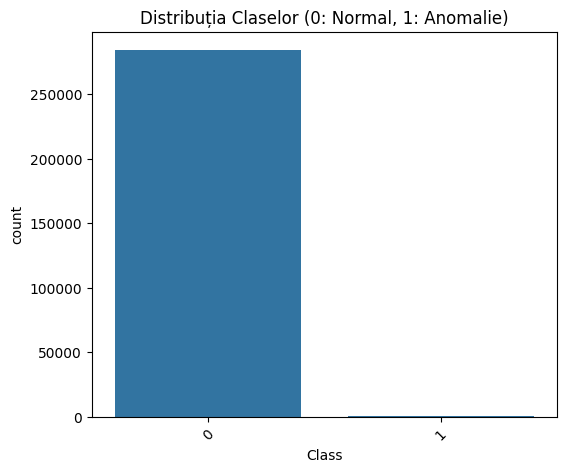

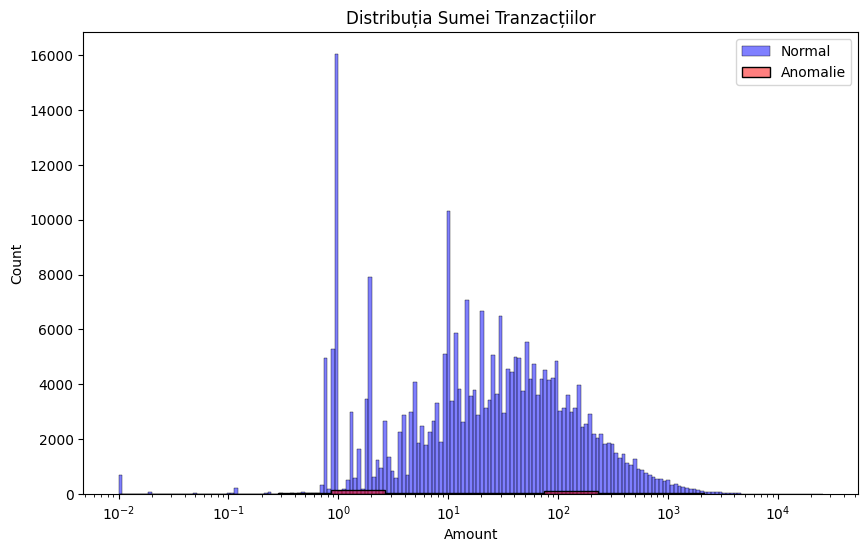

In [22]:
# CELULA 4 - Vizualizare distribuții și anomalii

# 1. Vizualizarea dezechilibrului clasei (Anomalii vs Normal)
plt.figure(figsize=(6,5))
plt.title('Distribuția Claselor (0: Normal, 1: Anomalie)')
sns.countplot(x='Class', data=df)
plt.title('Distribuția Claselor (0: Normal, 1: Anomalie)')
plt.xlabel('Class')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

# 2. Analiza distribuției pentru variabila 'Amount'
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Class'] == 0]['Amount'], color='blue', label='Normal', kde=True, log_scale=True)
sns.histplot(df[df['Class'] == 1]['Amount'], color='red', label='Anomalie', kde=True, log_scale=True)
plt.title('Distribuția Sumei Tranzacțiilor')
plt.legend()
plt.show()

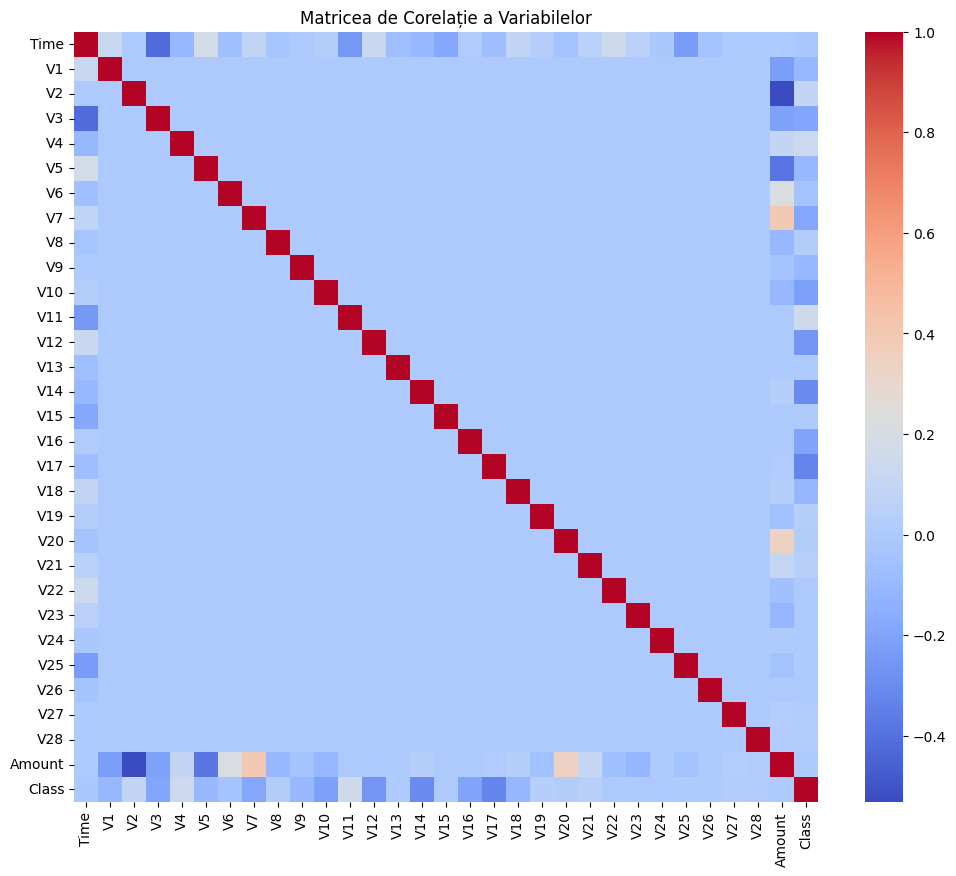

In [23]:
# CELULA 5: Corelatia si identificarea tiparelor.

plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Matricea de Corelație a Variabilelor')
plt.show()

## 4) Normalizarea datelor
Deoarece metodele folosite sunt sensibile la scala unităților de măsură, am folosit StandardScaler pentru a transforma cele 30 de variabile de intrare(Time, V1-V28, Amount).  

 Succesul standardizării a fost verificat prin metrici statistice, obținând o medie aproape de 0 și deviație standard 1.  

 Această normalizare este esențială pentru a preveni ca variabila Amount, cu valori mari, să domine celelalte variabile PCA (V1-V28), asigurând astfel o importanță echilibrată a tuturor caracteristicilor în detectarea fraudelor.

In [24]:
# CELULA 6: Normalizare

from sklearn.preprocessing import StandardScaler

# Recomandare: Scalarea datelor excluzand coloana 'Class'
scaler = StandardScaler()
X = df.drop('Class', axis=1)
X_scaled = scaler.fit_transform(X)

# Verificare: Media ar trebui sa fie ~0 si deviatia standard ~1
print(f"Media dupa scalare: {X_scaled.mean():.2f}")
print(f"Deviația standard dupa scalare: {X_scaled.std():.2f}")

Media dupa scalare: -0.00
Deviația standard dupa scalare: 1.00


# Metodele de detectare a anomaliilor utilizate

## 1) K-Nearest Neighbors-KNN



### a) Descrierea metodei  

Algoritmul KNN măsoara anormalitatea unui punct prin calcularea distanței față de al k-lea cel mai apropiat vecin. KNN pornește de la ipoteza că punctele normale au vecinii la distante mici, iar anomaliile sunt izolate.  

În cazul problemei noastre, KNN găsește tranzacțiile care nu sunt în tiparele dense de consum șî le marchează ca outliers.  







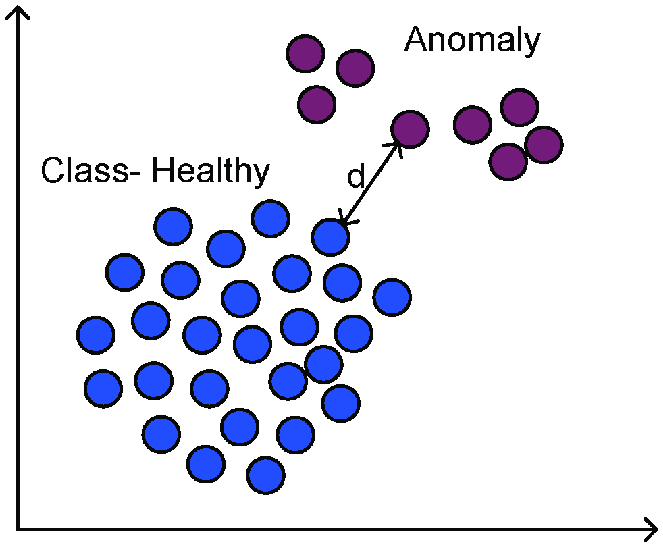


### b) Implementarea metodei  


*   Rata de contaminare a fost calculată anterior și ajută modelul să caute procentul real de fraude.
*   Prin teste repetate am observat ca n_neighbors=5 este valoarea optimă, care permite modelului să fie extrem de sensibil la anomaliile de tip cluster(fraudele).
* Au fost detectate 485 de anomalii cu ajutorul KNN, confirmând faptul că aproximativ 0.17% din tranzacții sunt fraude.






In [25]:
# CELULA 7 : KNN

from pyod.models.knn import KNN

# Procentul de contaminare (aprox. 0.17% conform analizei)
contamination_rate = 0.0017

# n_neighbors=5
clf_knn = KNN(contamination=contamination_rate, n_neighbors=5)

# Antrenarea modelului pe datele scalate
clf_knn.fit(X_scaled)

# Etichetele prezise (0 = normal, 1 = anomalie)
y_train_pred = clf_knn.labels_

# Scorurile de anomalie (cat de 'anormal' este fiecare punct)
y_train_scores = clf_knn.decision_scores_

print(f"Numar de anomalii detectate KNN: {sum(y_train_pred)}")

Numar de anomalii detectate KNN: 485


### c) Evaluarea performanței și interpretarea rezultatelor


*   Scorul Siluetă (0.8630) - ideal 1: confirmă o separare aproape ideală între tranzacțiile legitime și cele frauduloase si demonstrează că anomaliile detectate sunt foarte bine grupate și nu se suprapun cu zona de normalitate
*  Indicele Dunn (0.3111): arată un raport favorabil între distanța dintre clustere și densitatea lor
* Scorul Calinski-Harabasz - de coerență (420.63): are o valoare mare și indică faptul că modelul a identificat grupuri coerente și compacte
* Indicele Davies-Bouldin (1.5996) - ideal 0: indică o similitudine redusă între anomaliile detectate și datele normale

In [26]:
#CELULA 8: Evaluarea performantei KNN

from sklearn.metrics import silhouette_score
import numpy as np

# Iau 10.000 de puncte aleatorii pentru calculul Siluetei și Dunn
indices = np.random.choice(X_scaled.shape[0], 10000, replace=False)
X_sample = X_scaled[indices]
labels_sample = y_train_pred[indices]

# Calculul Scorului Siluetă
# Măsoară cât de bine sunt separate clusterele de anomalii de restul datelor
sil_score = silhouette_score(X_sample, labels_sample)

# Calculul Indicelui Dunn
# Indicele Dunn = distanța minimă între clustere / diametrul maxim al unui cluster
def dunn_index(X, labels):
    from sklearn.metrics.pairwise import euclidean_distances
    anomalies = X[labels == 1]
    normal = X[labels == 0]

    if len(anomalies) == 0: return 0

    # Distanța minimă între un punct normal și o anomalie (inter-cluster)
    inter_cluster_dist = np.min(euclidean_distances(normal, anomalies))

    # Diametrul maxim al clusterului normal (intra-cluster)
    intra_cluster_dist = np.max(euclidean_distances(normal[:500], normal[:500]))

    return inter_cluster_dist / intra_cluster_dist

dunn = dunn_index(X_sample, labels_sample)
print(f"--- Rezultate KNN ---")
print(f"Scorul Siluetă: {sil_score:.4f}")
print(f"Indicele Dunn: {dunn:.4f}")

from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Calinski-Harabasz: Cu cât este mai mare, cu atât grupurile sunt mai "coerente" și bine separate
ch_score = calinski_harabasz_score(X_sample, labels_sample)

# Davies-Bouldin: Cu cât este mai mic (mai aproape de 0), cu atât clusterizarea este mai bună
db_score = davies_bouldin_score(X_sample, labels_sample)

print(f"Scorul Calinski-Harabasz: {ch_score:.2f}")
print(f"Indicele Davies-Bouldin: {db_score:.4f}")

--- Rezultate KNN ---
Scorul Siluetă: 0.8630
Indicele Dunn: 0.3111
Scorul Calinski-Harabasz: 420.63
Indicele Davies-Bouldin: 1.5996


### d) Vizualizare metodă


* Deși modelul a lucrat în spațiul complet de 30 de dimensiuni pentru a detecta fraudele, am ales reprezentarea rezultatelor într-un spațiu bidimensional, pentru o vizualizare mai bună . V1 și V2 sunt primele componente principale care captează cea mai mare variabilitate a datelor, permițând observarea modului în care anomaliile sunt proiectate în afara distribuției principale a tranzacțiilor normale.
*   Punctele albastre arată tranzacțiile normale(dense), iar punctele roșii reprezintă anomaliile care nu sunt dispuse aleatoriu, ci formează grupuri izolate în partea inferioară a graficului.
*   Modelul a reușit să ignore majoritatea zgomotului din zona centrală și să izoleze corect tranzacțiile care deviază semnificativ de pe axa V2, identificând cu succes anomaliile.



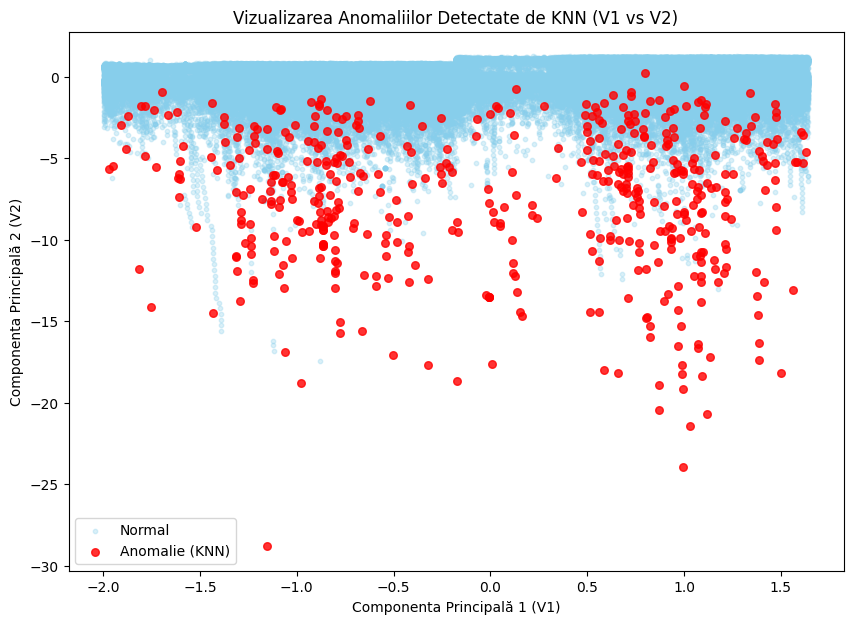

In [27]:
#CELULA 9:Vizualizare grafică KNN

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))

# Plotez punctele normale (label 0) cu albastru
plt.scatter(X_scaled[y_train_pred == 0, 0], X_scaled[y_train_pred == 0, 1],
            c='skyblue', label='Normal', alpha=0.3, s=10)

# Plotez anomaliile detectate (label 1) cu roșu
plt.scatter(X_scaled[y_train_pred == 1, 0], X_scaled[y_train_pred == 1, 1],
            c='red', label='Anomalie (KNN)', alpha=0.8, s=30)

plt.title('Vizualizarea Anomaliilor Detectate de KNN (V1 vs V2)')
plt.xlabel('Componenta Principală 1 (V1)')
plt.ylabel('Componenta Principală 2 (V2)')
plt.legend()
plt.show()

## 2) Lightweight Online Detector of Anomalies - LODA
### a) Descrierea metodei
LODA este un algoritm de ansamblu("ensamble"), construit în 2016 de către Tomáš Pevný pentru a fi rapid si eficient pe seturi mari de date.  

Această metodă proiectează datele multidimensionale pe mai mulți vectori aleatori unidimensionali. La fiecare proiecție se construiește o histogramă ce aproximează distrbuția de probabilitate, scorul final de anomalie fiind media logaritmică a densităților tuturor proiecțiilor.  

În problema noastră de 30 de dimensiuni, LODA captează rapid anomaliile care apar doar în anumite proiectii ale datelor(acolo unde am fraude0, fiind mult mai rapid decât celelalte metode folosite, bazate pe distanță.
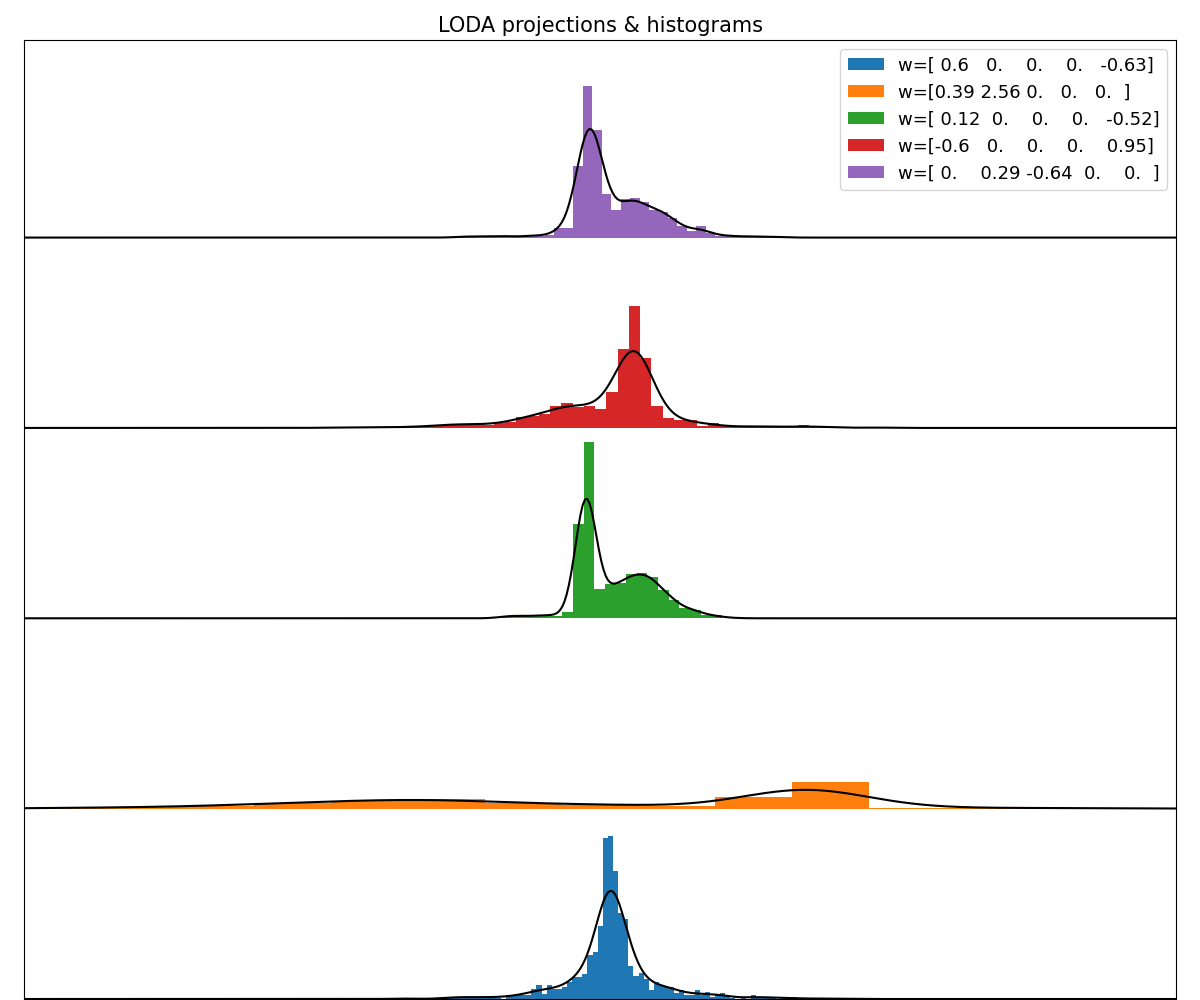
### b) Implementarea metodei  


*   Am păstrat aceeași rată de contaminare calculata anterior
*   Spre deosebire de KNN, LODA a computat aproape instantaneu setul de date => detector "lightweight"
* Implementănd această metodă am obținut tot 485 de anomalii, însă mult mai rapid



In [28]:
# CELULA 10: Implementare LODA

from pyod.models.loda import LODA
contamination_rate = 0.0017

clf_loda = LODA(contamination=contamination_rate)
clf_loda.fit(X_scaled)

y_pred_loda = clf_loda.labels_
print(f"Număr de anomalii detectate (LODA): {sum(y_pred_loda)}")

Număr de anomalii detectate (LODA): 485


### c) Evaluarea performanței și interpretarea rezultatelor


*  Scorul Siluetă (0.8417): valoarea este aproape identică cu cea a KNN (0.8549), ceea ce indică faptul că LODA a identificat un set de anomalii la fel de bine izolate față de restul datelor.
*   Indicele Dunn (0.0394):  valoarea sa este semnificativ mai mică decât la KNN (0.4515), fapt ce sugerează că, deși anomaliile sunt separate, "diametrul" grupului de date normale este considerat mai mare în raport cu distanța până la cea mai apropiată anomalie detectată de LODA.
* Scorul Calinski-Harabasz (283.79): arată o structură de cluster solidă, deși ușor mai puțin compactă decât cea obținută de KNN.
* Indicele Davies-Bouldin (2.0709): fiind mai mare decât la KNN (1.98), indică faptul că există o ușoară suprapunere mai mare între zonele de frontieră ale datelor normale și anomaliile găsite de histogramele LODA.

In [29]:
# CELULA 11: Evaluarea performantei LODA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

labels_sample_loda = y_pred_loda[indices]

sil_loda = silhouette_score(X_sample, labels_sample_loda)
ch_loda = calinski_harabasz_score(X_sample, labels_sample_loda)
db_loda = davies_bouldin_score(X_sample, labels_sample_loda)
dunn_loda = dunn_index(X_sample, labels_sample_loda)

print(f"--- Rezultate LODA ---")
print(f"Scorul Siluetă: {sil_loda:.4f}")
print(f"Indicele Dunn: {dunn_loda:.4f}")
print(f"Scorul Calinski-Harabasz: {ch_loda:.2f}")
print(f"Indicele Davies-Bouldin: {db_loda:.4f}")


--- Rezultate LODA ---
Scorul Siluetă: 0.8417
Indicele Dunn: 0.0394
Scorul Calinski-Harabasz: 283.79
Indicele Davies-Bouldin: 2.0709


### d) Vizualizare metodă


*   Punctele portocalii reprezintă cele 485 anomalii detectate, iar cele gri reprezintă datele normale(tranzacțiile nefrauduluase).

*   LODA tinde să marcheze puncte mai apropiate unele de altele, aflate în josul distribuției datelor, observându-se o suprapunere în acea zonă a graficului, confirmând faptul că tiparele de frauda vazute sunt anomalii de tip cluster.



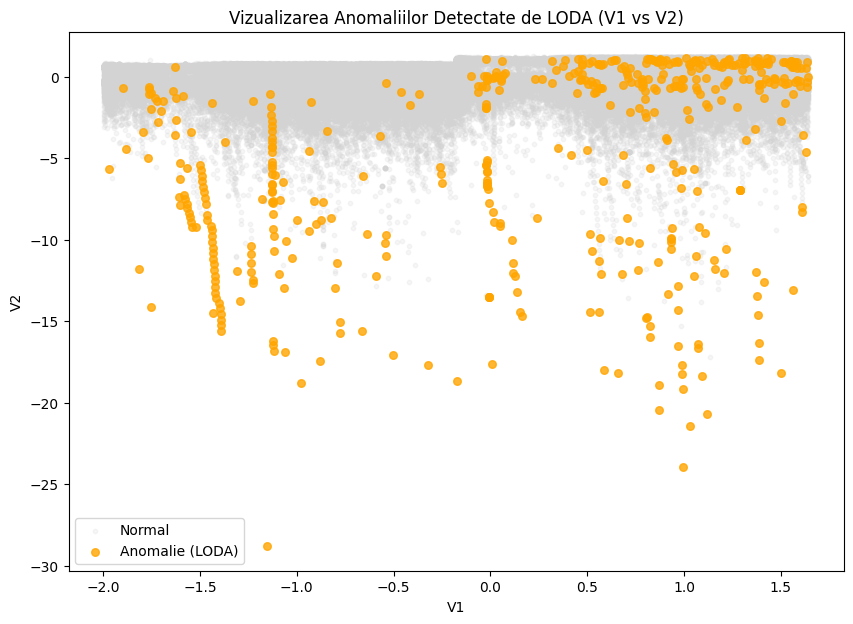

In [30]:
# CELULA 12: Vizualizare LODA
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))

# Puncte normale (label 0)
plt.scatter(X_scaled[y_pred_loda == 0, 0], X_scaled[y_pred_loda == 0, 1],
            c='lightgrey', label='Normal', alpha=0.2, s=10)

# Anomalii detectate de LODA (label 1)
plt.scatter(X_scaled[y_pred_loda == 1, 0], X_scaled[y_pred_loda == 1, 1],
            c='orange', label='Anomalie (LODA)', alpha=0.8, s=30)

plt.title('Vizualizarea Anomaliilor Detectate de LODA (V1 vs V2)')
plt.xlabel('V1')
plt.ylabel('V2')
plt.legend()
plt.show()

## 3) One-Class Support Vector Machine  - OCSVM
### a) Descrierea metodei
One-Class SVM este o adaptare a algoritmului clasic SVM de învățare nesupervizată, utilizat pentru estimarea suportului unei distribuții.  

Metoda mapează datele într-un spațiu de dimensiuni superioare, folosindu-se de un kernel(RBF) și încearcă să găsească un hiper-plan caresepară datele de origine. Daterle care cad în afara frontierei stabilite sunt marcate ca anomalii.  

Pentru problema data, OCSVM permite identificarea unor tipare de fraudă foarte subtile acolo unde tranbzacțiile nu formează o formă geometrică simplă.
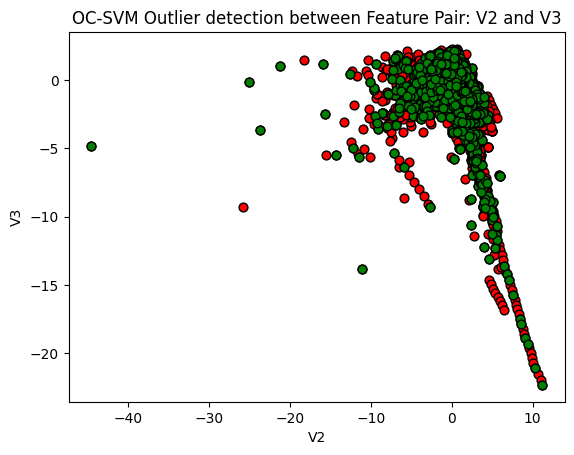
### b) Implementarea metodei  


*   Din cauza complexității ridicate a modelului(O($ n^2 $)), a trebuit să optimizez antrenarea pe un subset de 50000 de date, reducând semnificativ timpul de compilare.
*   Deși antrenarea s-a făcut pe un subset, am configurat modelul să realizeze predicția pe întregul set de date, asigurând acoperirea globală a tranzacțiilor.
* Am ales kernel-ul Radial Basis Function(RBF), permițând astfel modelului să identifice frontiere neliniare, esențiale pentru detectarea anomaliilor de tip cluster.
* Numărul mare de anomalii detectate(1031), care depășește considerabil cele 0.17% fraude descoperite anterior, arată că modelul este mult mai sensibil, generând multe rezultate de tip Fals Pozitiv. OCSVM a trasat o frontieră mult mai strictă, marcând ca anomalii și puncte care se află la marginea normalității, nu doar pe cele din clusterele dense de fraudă.



In [31]:
# CELULA 13: One-Class SVM
from pyod.models.ocsvm import OCSVM
contamination_rate = 0.0017

clf_ocsvm = OCSVM(contamination=contamination_rate, kernel='rbf')

# Antrenez pe un subset de 50.000 de rânduri pentru viteză
clf_ocsvm.fit(X_scaled[:50000])

# Generarez predicțiile pentru ÎNTREGUL set de date
y_pred_ocsvm = clf_ocsvm.predict(X_scaled)

# Obțin scorurile pentru întregul set de date
y_scores_ocsvm = clf_ocsvm.decision_function(X_scaled)

print(f"Număr de anomalii detectate (OCSVM) pe tot setul: {sum(y_pred_ocsvm)}")

Număr de anomalii detectate (OCSVM) pe tot setul: 1031


### c) Evaluarea performanței și interpretarea rezultatelor

* Scorul Siluetă (0.8264): arată o separare foarte bună, anomaliile fiind clar distinse de datele normale, chiar dacă granița este mai complexă decât la KNN.
* Indicele Dunn (0.2691): confirmă existența unor clustere de anomalii, dar sugerează că acestea sunt mai apropiate de datele normale sau mai împrăștiate față de restul modelelor.
* Scorul Calinski-Harabasz (242.74): demonstrează că grupurile de anomalii au o structură internă coerentă și nu sunt doar puncte de zgomot izolate.
* Indicele Davies-Bouldin (2.2864): având o valoare mai ridicată, arată o similitudine mai mare între anomalii și normalitate, explicând de ce modelul a fost mai strict și a găsit mai multe puncte suspecte.

In [32]:
# CELULA 14: Evaluare performante OCSVM
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

labels_sample_ocsvm = y_pred_ocsvm[indices]

sil_ocsvm = silhouette_score(X_sample, labels_sample_ocsvm)
ch_ocsvm = calinski_harabasz_score(X_sample, labels_sample_ocsvm)
db_ocsvm = davies_bouldin_score(X_sample, labels_sample_ocsvm)
dunn_ocsvm = dunn_index(X_sample, labels_sample_ocsvm)

print(f"--- Rezultate One-Class SVM ---")
print(f"Scorul Siluetă: {sil_ocsvm:.4f}")
print(f"Indicele Dunn: {dunn_ocsvm:.4f}")
print(f"Scorul Calinski-Harabasz (Coerență): {ch_ocsvm:.2f}")
print(f"Indicele Davies-Bouldin: {db_ocsvm:.4f}")


--- Rezultate One-Class SVM ---
Scorul Siluetă: 0.8064
Indicele Dunn: 0.2691
Scorul Calinski-Harabasz (Coerență): 242.74
Indicele Davies-Bouldin: 2.2864


### d) Vizualizare metodă

* Punctele roz reprezintă fraudele detctate, iar cele gri sunt tranzactiile normale.
* Se observă că fraudele acoperă o zonă mult mai mare față de cele 2 metode prezentate anterior, demonstrând sensibilitatea algoritmului, care consideră marginea inferioară a distribuției ca fiind zonă de risc.

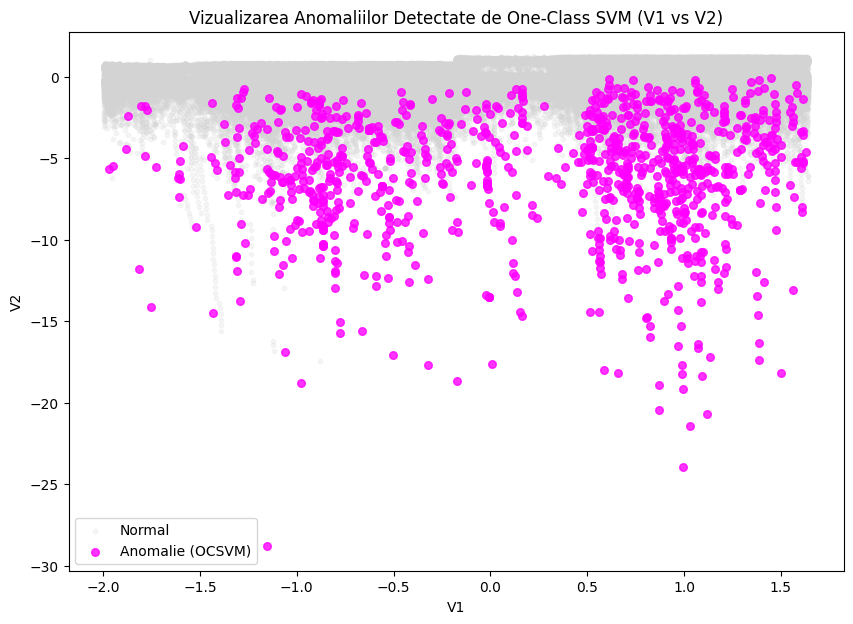

In [33]:
# CELULA 15: Vizualizare OCSVM
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))

# Puncte normale (label 0)
plt.scatter(X_scaled[y_pred_ocsvm == 0, 0], X_scaled[y_pred_ocsvm == 0, 1],
            c='lightgrey', label='Normal', alpha=0.2, s=10)

# Anomalii detectate de OCSVM (label 1)
plt.scatter(X_scaled[y_pred_ocsvm == 1, 0], X_scaled[y_pred_ocsvm == 1, 1],
            c='magenta', label='Anomalie (OCSVM)', alpha=0.8, s=30)

plt.title('Vizualizarea Anomaliilor Detectate de One-Class SVM (V1 vs V2)')
plt.xlabel('V1')
plt.ylabel('V2')
plt.legend()
plt.show()

# Comparații metode

1)  **KNN** - cea mai precisă metodă datorită Scorului de Siluetă obținut(cel mai aproape de 1) și al scorului de coerență ridicat. Acest lucru demonstrează că fraudele din acest set de date tind să formeze clustere izolate și compacte, KNN excelând la identificarea anomaliilor bazate pe densitate locală.  
2) **LODA** - cea mai eficientă ca și viteză, reușind într-un timp de execuție semnificativ mai mic să identifice acelasi număr de anomalii ca și KNN. Astfel se demonstrează că LODA este eficient pentru sistemele de monitorizare în timp real, cum ar fi sistemele de detcție a fraudelor bancare.  
3) **OCSVM** -  a detectat un număr mult mai mare de anomalii (1031), depășind rata de contaminare setată. Aceasta explică scorurile ușor mai mici: prin extinderea frontierei de detecție pentru a prinde anomalii mai subtile, a inclus și puncte aflate la limita normalității, scăzând puritatea geometrică a clusterelor.  

Din graficele generate (V1 vs V2), se remarcă că toate cele trei metode au identificat nucleul dur de anomalii situat în partea inferioară a axei $V2$. Aceasta confirmă faptul că acele tranzacții sunt in mod sigur frauduloase (anomalii globale).Totusi, în timp ce KNN și LODA sunt foarte selective, concentrându-se doar pe punctele cele mai îndepărtate, OCSVM  acoperă norul de date normale într-o zonă de siguranță mult mai largă, fiind singurul care a penalizat tranzacțiile de tip borderline.

In [34]:
# CELULA 16: Comparatii Performanțe

rezultate = pd.DataFrame({
    'Metoda': ['KNN', 'LODA', 'OCSVM'],
    'Silueta': [sil_score, sil_loda, sil_ocsvm],
    'Indice Dunn': [dunn, dunn_loda, dunn_ocsvm],
    'Scor Coerență ': [ch_score, ch_loda, ch_ocsvm],
    'Anomalii Detectate': [sum(y_train_pred), sum(y_pred_loda), sum(y_pred_ocsvm)]
})

pd.options.display.float_format = '{:.4f}'.format
print(rezultate )

  Metoda  Silueta  Indice Dunn  Scor Coerență   Anomalii Detectate
0    KNN   0.8630       0.3111        420.6263                 485
1   LODA   0.8417       0.0394        283.7869                 485
2  OCSVM   0.8064       0.2691        242.7423                1031


# Concluzii
Proiectul demonstrat complexitatea și provocările detectării fraudelor bancare într-un mediu nesupervizat. Prin implementarea a metode distincte: KNN, LODA și One-Class SVM am reușit tranformarea un set de date brut și dezechilibrat într-o analiză structurată a comportamentelor tranzacționale anormale. Astfel, demonstrăm că nu există o "cea mai bună metodă", alegerea făcându-se în funcție de ce ne dorim să obținem:

 * Pentru precizie maximă și reducerea alarmelor false: KNN este alegerea optimă, având cele mai solide metrici de separare.

 * Pentru procesare rapidă pe volume masive de date: LODA oferă cel mai bun  raport performanță/viteză.

 * Pentru securitate ridicată (unde preferăm să verificăm o tranzacție normală decât să scăpăm o fraudă): OCSVM este cel mai indicat datorită sensibilității sale crescute.

 Așadar, consider că abordarea de tip ansamblu (combinarea rezultatelor celor trei modele) ar reprezenta cea mai robustă soluție pentru un sistem real de antifraudă, echilibrând precizia geometrică a KNN cu sensibilitatea OCSVM și viteza LODA.

#Bibliografie
 * Dataset:[Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data)
 * Vizualizare fraude: [Kaggle example](https://www.kaggle.com/code/mohamed168/credit-card-fraud-analysis-visualization)
 * Documentație Framework:[PyOD Official Documentation](https://pyod.readthedocs.io/en/latest/)
 * Algoritmi de detectie a anomaliilor:
  [KNN for Anomaly Detection - ResearchGate Illustration](https://www.researchgate.net/figure/Anomaly-detection-using-a-KNN_fig12_349412387),  [One Class SVM Geeksforgeeks](https://www.geeksforgeeks.org/machine-learning/understanding-one-class-support-vector-machines/), [LODA - Anlearn Documentation](https://anlearn.readthedocs.io/en/latest/loda.html)
*  Implementare Practică: [Anomaly Detection with pyOD](https://medium.com/data-reply-it-datatech/anomaly-detection-made-easy-with-pyod-960faf6da4e5)
* Evaluarea Performanței: [Metrice de evaluare](https://www.geeksforgeeks.org/machine-learning/clustering-metrics/)
